In [1]:
from fastai.vision.all import *
import torchvision

def random_seed(seed_value, use_cuda):  #gleaned from multiple forum posts
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: torch.cuda.manual_seed_all(seed_value) # gpu 


random_seed(42,True)

path=Path("/kaggle/input/lfw-yyy2-lbq")
files=get_image_files(path)
def halftone(img):
    if isinstance(img, PILImage):
        img1=img.convert("1").convert("L")
        return img1
    else:
        return img
    
def gray(img):
    if isinstance(img, PILImage):
        img1=img.convert("L")
        return img1
    else:
        return img

In [2]:
# 定义label_func函数
def label_func(filepath):
    return filepath.parent.name

class TripletImage(fastuple):
    def show(self, loss=None, pred=None, p=None, ctx=None, **kwargs): 
        if len(self) > 3:
                img1,img2,img3,similarity = self
        else:
            img1,img2,img3 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            if img3.size != img1.size: img3 = img3.resize(img1.size)
            t1,t2,t3 = tensor(img1),tensor(img2), tensor(img3)
            t1,t2,t3 = t1.permute(2,0,1),t2.permute(2,0,1),t3.permute(2,0,1)
        else: t1,t2,t3 = img1,img2,img3
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        if loss == None:
            return show_image(torch.cat([t2,line,t1,line,t3], dim=2), title=similarity, ctx=ctx, **kwargs)
        elif pred == None:
            return show_image(torch.cat([t2,line,t1,line,t3], dim=2), title=f"{loss:.2f}", ctx=ctx, **kwargs)
        return show_image(torch.cat([t2,line,t1,line,t3], dim=2), title=f"{pred}/{similarity} {loss:.2f} / {p:.2f}", ctx=ctx, **kwargs)

class TripletTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(get_image_files(path/l)) for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2, f3, anchor = self.valid.get(f, self._draw(f,0))
        img1,img2,img3 = PILImage.create(f),PILImage.create(f2),PILImage.create(f3)
        return TripletImage(img1, img2, img3, anchor)
    
    def _draw(self, f, split=0):
        cls1 = label_func(f)
        cls2 = random.choice(L(l for l in labels if l != cls1))
        while len(self.lbl2files[cls2]) == 0: 
            cls2 = random.choice(L(l for l in labels if l != cls1))
        return random.choice(self.lbl2files[cls1]),random.choice(self.lbl2files[cls2]),cls1
    
@typedispatch
def show_batch(x:TripletImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): TripletImage(x[0][i], x[1][i], x[2][i], x[3][i]).show(ctx=ctx)
    
splits = RandomSplitter()(files)
labels = list(set(files.map(label_func)))
tfm = TripletTransform(files, parent_label, splits)
tls = TfmdLists(files, tfm, splits=splits)

dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

#*aug_transforms()
class TripletModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    def forward(self, x1, x2, x3):
        x1 = self.encoder(x1)
        x2 = self.encoder(x2)
        x3 = self.encoder(x3)
        x1 = self.head(x1)
        x2 = self.head(x2)
        x3 = self.head(x3)
        return x1, x2, x3

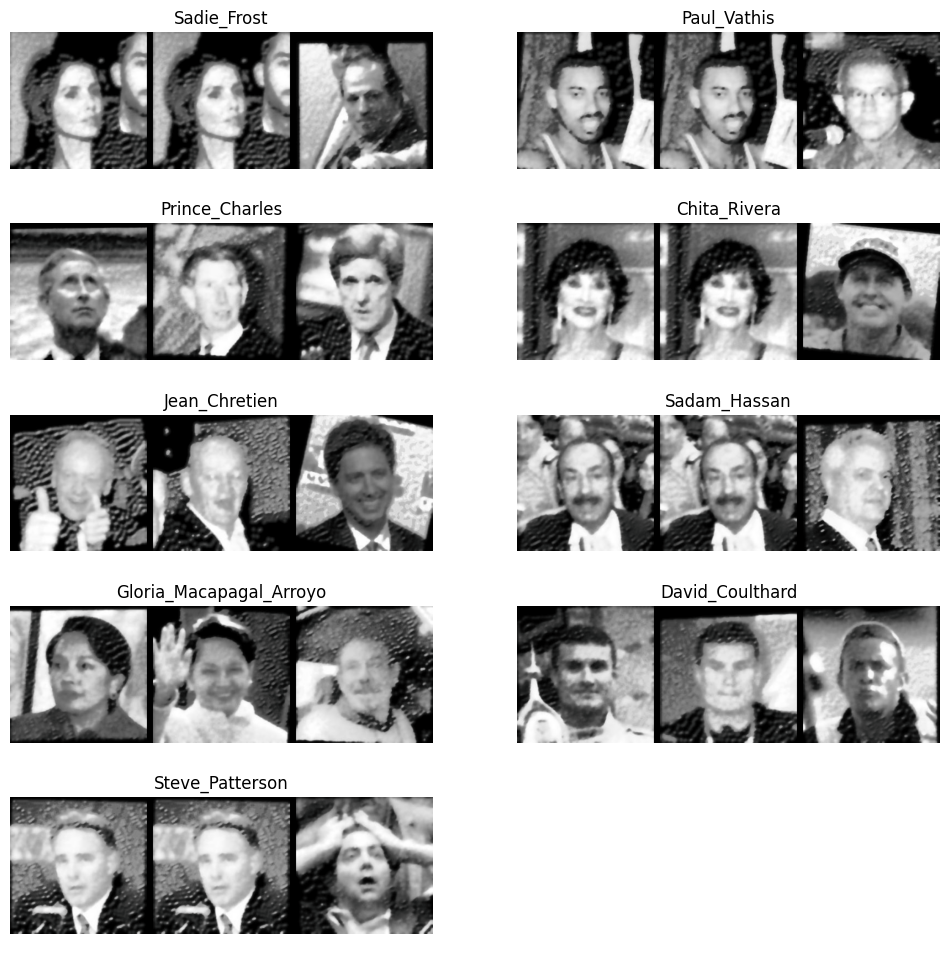

In [3]:
dls.show_batch()

In [4]:
EffNet=mobilenet_v2(weights="DEFAULT")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = create_body(EffNet, cut=-1)
head = create_head(1280, 256, [1024,512], 0.5, bn_final=True)
model = TripletModel(encoder, head)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 130MB/s]


In [5]:
from fastai.optimizer import Adam

class _Loss(Module):
    reduction: str
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction: str = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction
class triplet_loss_func(_Loss):
    __constants__ = ['margin', 'p', 'eps', 'swap', 'reduction']
    margin: float
    p: float
    eps: float
    swap: bool

    def __init__(self, margin: float = 1.0, p: float = 2., eps: float = 1e-6, swap: bool = False, size_average=None,
                 reduce=None, reduction: str = 'mean'):
        super(triplet_loss_func, self).__init__(size_average, reduce, reduction)
        self.margin = margin
        self.p = p
        self.eps = eps
        self.swap = swap

    def forward(self, x, *args):
        anchor, positive, negatives = x[0], x[1], x[2:]
        
        # 计算 anchor 与 positive 的距离的平方
        pos_dist_sq = torch.sum((anchor - positive) ** 2, dim=1)
        
        # 初始化负样本与锚点之间的距离的列表
        neg_dists_sq = []
        
        # 计算负样本与锚点之间的距离的平方
        for neg in negatives:
            neg_dist_sq = torch.sum((anchor - neg) ** 2, dim=1)
            neg_dists_sq.append(neg_dist_sq)
        
        # 将负样本之间的距离的平方堆叠起来
        neg_dists_sq = torch.stack(neg_dists_sq, dim=1)
        
        # 选择每个样本的最具挑战性的负样本的索引
        hard_neg_indices = torch.argmin(neg_dists_sq, dim=1)
        
        # 根据索引选择最具挑战性的负样本的距离的平方
        hard_neg_dist_sq = torch.gather(neg_dists_sq, dim=1, index=hard_neg_indices.unsqueeze(1))
        
        # 计算 loss
        losses = F.relu(pos_dist_sq - hard_neg_dist_sq + self.margin)
        
        if self.reduction == 'mean':
            return torch.mean(losses)
        elif self.reduction == 'sum':
            return torch.sum(losses)
        else:
            return losses

def triplet_splitter(model):
    return [params(model.encoder), params(model.head)]
    
def accuracy(ops, targets):
    op1, op2, op3 = ops[0], ops[1], ops[2]
    pos_dists = F.pairwise_distance(op1, op2)
    neg_dists = F.pairwise_distance(op1, op3)
    dists = torch.cat([pos_dists, neg_dists])
    targets = [1] * len(pos_dists) + [0] * len(neg_dists)
    targets = torch.tensor(targets).to(device)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    true_negatives = torch.sum((preds == 0) & (targets == 0)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives) if (true_positives + true_negatives + false_positives + false_negatives) > 0 else 0.0

    return accuracy

def precison(ops, targets):
    op1, op2, op3 = ops[0], ops[1], ops[2]
    pos_dists = F.pairwise_distance(op1, op2)
    neg_dists = F.pairwise_distance(op1, op3)
    dists = torch.cat([pos_dists, neg_dists])
    targets = [1] * len(pos_dists) + [0] * len(neg_dists)
    targets = torch.tensor(targets).to(device)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0

    return precision

def recall(ops, targets):
    op1, op2, op3 = ops[0], ops[1], ops[2]
    pos_dists = F.pairwise_distance(op1, op2)
    neg_dists = F.pairwise_distance(op1, op3)
    dists = torch.cat([pos_dists, neg_dists])
    targets = [1] * len(pos_dists) + [0] * len(neg_dists)
    targets = torch.tensor(targets).to(device)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0

    return recall

def f1_score(ops, targets):
    op1, op2, op3 = ops[0], ops[1], ops[2]
    pos_dists = F.pairwise_distance(op1, op2)
    neg_dists = F.pairwise_distance(op1, op3)
    dists = torch.cat([pos_dists, neg_dists])
    targets = [1] * len(pos_dists) + [0] * len(neg_dists)
    targets = torch.tensor(targets).to(device)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return f1_score

class OptimalThreshold:
    def __init__(self, start=0.1, end=3.0, step=0.01):
        self.start = start
        self.end = end
        self.step = step
        self.best_threshold = None

    def find(self, preds, targets):
        best_accuracy = 0.0
        for threshold in np.arange(self.start, self.end, self.step):
            preds_thresholded = (preds < threshold).float()
            accuracy = (preds_thresholded == targets).float().mean()
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                self.best_threshold = threshold
                
class PrintBestThreshold(Callback):
    def after_epoch(self):
        print(f"Epoch {self.learn.epoch} LR:{self.opt.hypers[0]['lr']:.10f} Best threshold: {optimal_threshold.best_threshold:.2f}")

optimal_threshold = OptimalThreshold()

learn = Learner(dls, model, loss_func=triplet_loss_func(margin=1.00), opt_func=Adam,
                splitter=triplet_splitter, metrics=[accuracy,precison,recall,f1_score],cbs=PrintBestThreshold())

In [6]:
learn.freeze()
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,precison,recall,f1_score,time
0,21.619480,20.665241,0.720644,1.000000,0.441288,0.608700,01:34
1,7.366990,2.320458,0.721760,1.000000,0.443520,0.610803,01:19
2,0.852601,0.233620,0.844984,0.872448,0.817539,0.839761,01:18
3,0.250208,0.184981,0.851478,0.874709,0.828294,0.846690,01:18
4,0.205511,0.172801,0.860542,0.868482,0.855384,0.859400,01:19
5,0.195658,0.158782,0.868016,0.885295,0.849060,0.864980,01:18
6,0.197383,0.146208,0.876928,0.895695,0.859138,0.874452,01:19
7,0.169740,0.124634,0.886989,0.887809,0.890794,0.887277,01:20
8,0.139427,0.102485,0.900534,0.899720,0.905202,0.901062,01:20
9,0.116221,0.096255,0.905743,0.905073,0.909328,0.906002,01:19


Epoch 0 LR:0.0036819944 Best threshold: 0.10
Epoch 1 LR:0.0090616818 Best threshold: 0.10
Epoch 2 LR:0.0098933623 Best threshold: 1.68
Epoch 3 LR:0.0090525423 Best threshold: 1.16
Epoch 4 LR:0.0075110095 Best threshold: 1.35
Epoch 5 LR:0.0055353087 Best threshold: 1.40
Epoch 6 LR:0.0034670576 Best threshold: 1.26
Epoch 7 LR:0.0016638736 Best threshold: 1.05
Epoch 8 LR:0.0004375461 Best threshold: 1.21
Epoch 9 LR:0.0000001161 Best threshold: 1.20


In [7]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,precison,recall,f1_score,time
0,0.111557,0.091720,0.909835,0.914637,0.906690,0.909097,01:38
1,0.112834,0.086555,0.910765,0.913591,0.910038,0.910494,01:38
2,0.109049,0.084046,0.910782,0.906275,0.919000,0.911073,01:38
3,0.105413,0.080774,0.914688,0.918086,0.913082,0.914385,01:38
4,0.104248,0.088210,0.909294,0.912330,0.909700,0.909232,01:39
5,0.097956,0.074642,0.922112,0.924597,0.921232,0.921820,01:39
6,0.093939,0.075257,0.919152,0.922559,0.917140,0.918703,01:38
7,0.081879,0.063291,0.929366,0.929638,0.930465,0.929304,01:38
8,0.081084,0.055014,0.938295,0.937790,0.940206,0.938401,01:38
9,0.073158,0.052849,0.939597,0.932818,0.949033,0.940159,01:38


Epoch 0 LR:0.0000013060 Best threshold: 1.29
Epoch 1 LR:0.0000036993 Best threshold: 1.28
Epoch 2 LR:0.0000066659 Best threshold: 1.31
Epoch 3 LR:0.0000090725 Best threshold: 1.19
Epoch 4 LR:0.0000100000 Best threshold: 1.29
Epoch 5 LR:0.0000098921 Best threshold: 1.27
Epoch 6 LR:0.0000095703 Best threshold: 1.29
Epoch 7 LR:0.0000090488 Best threshold: 1.34
Epoch 8 LR:0.0000083504 Best threshold: 1.19
Epoch 9 LR:0.0000075055 Best threshold: 1.58
Epoch 10 LR:0.0000065512 Best threshold: 1.51
Epoch 11 LR:0.0000055290 Best threshold: 1.37
Epoch 12 LR:0.0000044837 Best threshold: 1.61
Epoch 13 LR:0.0000034610 Best threshold: 1.48
Epoch 14 LR:0.0000025056 Best threshold: 1.41
Epoch 15 LR:0.0000016591 Best threshold: 1.38
Epoch 16 LR:0.0000009587 Best threshold: 1.54
Epoch 17 LR:0.0000004350 Best threshold: 1.60
Epoch 18 LR:0.0000001107 Best threshold: 1.53
Epoch 19 LR:0.0000000001 Best threshold: 1.54


In [8]:
#learn.export('EffNet_V2_M_nExt_Filtter_256Emb_TriLoss.pkl')
#learn = load_learner('.pkl', cpu=False)